<a href="https://colab.research.google.com/github/krishnapatil343/Krishna-Patil/blob/main/Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## EO Summer School (Hackathon) Submitted by Howard Van Meer and Krishna Arun Patil

## Global precipitation data fusion at 10 km
Spacetime modelling of monthly precipitation through multi-source data fusion

## Overview
This hackathon focuses on developing a fused global precipitation product at 10 km spatial resolution for the period 2000–2016. Participants will integrate three complementary monthly precipitation datasets, ERA5 (10 km), CHELSA (1 km), and IMERG (total accumulation, liquid accumulation, liquid rate at 10 km), to generate robust estimates of mean monthly precipitation. The training framework will leverage the GSOD station network (~15,000 stations), incorporating predictors such as ERA5, CHELSA, IMERG components, and auxiliary variables (minimum/maximum geometric temperature).

Goal: Develop a spacetime machine-learning model that fuses global datasets to predict monthly precipitation (2000–2016), validated against station time series using coefficient of determination (R²) in log-scale (log(1 + PRCP)).

## Dataset Description
The Global Surface Summary of the Day (GSOD) provides long-term, quality-controlled daily weather observations from thousands of meteorological stations worldwide. For this hackathon, we use GSOD precipitation stations (~15,000 globally) as the ground-truth reference to train and validate precipitation data fusion models. Here is the spatial distribution of the GSOD precipitation stations:

## Goal
Your task is to build ML models that predict global monthly precipitation at 10 km resolution, capturing both spatial heterogeneity and temporal dynamics. The challenge is not only to maximize predictive accuracy, but also to advance data fusion methodologies that leverage the strengths of reanalysis, satellite, and station data in a unified framework.

In [ ]:
# Try LightGBM (fast), else XGBoost, else sklearn GradientBoosting
ModelLib = None
try:
    import lightgbm as lgb
    ModelLib = "lightgbm"
except Exception:
    try:
        import xgboost as xgb
        ModelLib = "xgboost"
    except Exception:
        from sklearn.ensemble import GradientBoostingRegressor
        ModelLib = "sklearn"

from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
print("Using:", ModelLib)


Using: sklearn


In [ ]:
# === EDIT THESE ===
TRAIN_PATH = "/Users/krishnapatil/Desktop/Hackathon/train.csv"
TEST_PATH  = "/Users/krishnapatil/Desktop/Hackathon/test.csv"

# ================ NO EDITS BELOW ================
import sys, os, math, numpy as np, pandas as pd

for p in (TRAIN_PATH, TEST_PATH):
    if not os.path.exists(p):
        raise FileNotFoundError(f"Not found: {p}")

# Optional: quiet warnings
import warnings; warnings.filterwarnings("ignore")
print("OK: found train/test files.")

OK: found train/test files.


In [ ]:
train_df = pd.read_csv(TRAIN_PATH)
test_df  = pd.read_csv(TEST_PATH)

# Try to find an ID column (used for grouping + submission)
ID_CANDIDATES = ["HACKATHON_ID", "STATION_ID", "station_id", "id"]
id_col = next((c for c in ID_CANDIDATES if c in train_df.columns), None)
if id_col is None:
    guess = [c for c in train_df.columns if "id" in c.lower() or "station" in c.lower()]
    id_col = guess[0] if guess else train_df.columns[0]

# Target: prefer PRCP_LOG, else compute log1p(PRCP)
if "PRCP_LOG" in train_df.columns:
    y_log = train_df["PRCP_LOG"].astype(float)
elif "PRCP" in train_df.columns:
    y_log = np.log1p(train_df["PRCP"].astype(float))
else:
    raise ValueError("Expected PRCP_LOG or PRCP in train.csv")

print("Rows:", len(train_df), "| id_col:", id_col, "| target: log space")
train_df.head(3)


Rows: 1234839 | id_col: HACKATHON_ID | target: log space


,HACKATHON_ID,DATE,TMIN_GEOM,TMAX_GEOM,PRCP,PRCP_CHELSA,PRCP_ERA5,PRCP_TOTAL_IMERG,PRCP_LIQUID_IMERG,PRCP_ICE_IMERG
0,8673f65a29bb_2000_01,2000-01-15,-21.682224,-16.939863,1.854200,7417.0,0.002035,13.0,1.0,12.0
1,8673f65a29bb_2000_02,2000-02-15,-20.011129,-15.299306,2.249714,9033.0,0.002736,23.0,2.0,21.0
2,8673f65a29bb_2000_03,2000-03-15,-15.038525,-10.417571,3.031067,14646.0,0.003942,64.0,3.0,61.0


In [ ]:
# Base predictors commonly present in this hackathon
base_feats = [c for c in [
    "PRCP_CHELSA","PRCP_ERA5","PRCP_TOTAL_IMERG",
    "PRCP_LIQ_IMERG","PRCP_LIQRATE_IMERG",  # if you have them
    "temp_min","temp_max","lat","lon","month","year"
] if c in train_df.columns]

if len(base_feats) == 0:
    # Fallback: all numeric predictors except target and id
    exclude = {"PRCP","PRCP_LOG", id_col}
    base_feats = [c for c in train_df.columns
                  if c not in exclude and np.issubdtype(train_df[c].dtype, np.number)]

# Add a few cheap, effective fusion features
def add_fusion_features(df):
    out = df.copy()
    for c in ["PRCP_CHELSA","PRCP_ERA5","PRCP_TOTAL_IMERG"]:
        if c in out.columns:
            out[c+"_log1p"] = np.log1p(out[c].clip(lower=0))
    if set(["PRCP_ERA5","PRCP_CHELSA"]).issubset(out.columns):
        out["era5_over_chelsa"]  = (out["PRCP_ERA5"]+1e-6)/(out["PRCP_CHELSA"]+1e-6)
    if set(["PRCP_TOTAL_IMERG","PRCP_CHELSA"]).issubset(out.columns):
        out["imerg_over_chelsa"] = (out["PRCP_TOTAL_IMERG"]+1e-6)/(out["PRCP_CHELSA"]+1e-6)
    return out

trainX = add_fusion_features(train_df)
testX  = add_fusion_features(test_df)

extra_feats = [c for c in trainX.columns if c.endswith("_log1p") or "over_chelsa" in c]
features = base_feats + extra_feats

# Keep only numeric features
features = [f for f in features if f in trainX.columns and np.issubdtype(trainX[f].dtype, np.number)]
print("Using features:", features)


Using features: ['PRCP_CHELSA', 'PRCP_ERA5', 'PRCP_TOTAL_IMERG', 'PRCP_CHELSA_log1p', 'PRCP_ERA5_log1p', 'PRCP_TOTAL_IMERG_log1p', 'era5_over_chelsa', 'imerg_over_chelsa']


In [ ]:
# Impute missing on TRAIN ONLY to avoid leakage
imp = SimpleImputer(strategy="median")
X_full = imp.fit_transform(trainX[features])
groups = train_df[id_col].astype(str).values  # clean groups

# 5-fold GroupKFold CV in log space (matches leaderboard metric)
gkf = GroupKFold(n_splits=5)
oof = np.zeros(len(train_df), dtype=float)

fold = 1
for tr_idx, val_idx in gkf.split(X_full, y_log.values, groups):
    X_tr, y_tr = X_full[tr_idx], y_log.values[tr_idx]
    X_va, y_va = X_full[val_idx], y_log.values[val_idx]

    if ModelLib == "lightgbm":
        model = lgb.LGBMRegressor(
            n_estimators=4000, learning_rate=0.03,
            num_leaves=64, min_data_in_leaf=50,
            feature_fraction=0.8, bagging_fraction=0.8, bagging_freq=1,
            reg_lambda=1.0, random_state=42
        )
        model.fit(X_tr, y_tr,
                  eval_set=[(X_va, y_va)],
                  eval_metric="rmse",
                  callbacks=[lgb.early_stopping(200, verbose=False)])
    elif ModelLib == "xgboost":
        model = xgb.XGBRegressor(
            n_estimators=5000, learning_rate=0.03, max_depth=6,
            subsample=0.8, colsample_bytree=0.8,
            reg_lambda=1.0, tree_method="hist", n_jobs=-1, random_state=42
        )
        model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)],
                  eval_metric="rmse", verbose=False, early_stopping_rounds=200)
    else:
        model = GradientBoostingRegressor(
            n_estimators=800, max_depth=3, learning_rate=0.05, subsample=0.9, random_state=42
        )
        model.fit(X_tr, y_tr)  # sklearn GBDT has no early stopping

    oof[val_idx] = model.predict(X_va)
    print(f"Fold {fold} done."); fold += 1

print("CV R^2 (log space):", r2_score(y_log.values, oof))

Fold 1 done.
Fold 2 done.
Fold 3 done.
Fold 4 done.
Fold 5 done.
CV R^2 (log space): 0.5758910198276384


In [ ]:
# Refit on all training data with chosen library + params
if ModelLib == "lightgbm":
    final = lgb.LGBMRegressor(
        n_estimators= int(1.2 * np.median([2000, 3000, 4000])),  # simple heuristic
        learning_rate=0.03, num_leaves=64, min_data_in_leaf=50,
        feature_fraction=0.8, bagging_fraction=0.8, bagging_freq=1,
        reg_lambda=1.0, random_state=42
    )
elif ModelLib == "xgboost":
    final = xgb.XGBRegressor(
        n_estimators= int(1.2 * np.median([3000, 4000, 5000])),
        learning_rate=0.03, max_depth=6, subsample=0.8,
        colsample_bytree=0.8, reg_lambda=1.0, tree_method="hist", n_jobs=-1, random_state=42
    )
else:
    final = GradientBoostingRegressor(
        n_estimators=900, max_depth=3, learning_rate=0.05, subsample=0.9, random_state=42
    )

final.fit(X_full, y_log.values)

# Prepare test features with SAME imputer
X_test = imp.transform(testX[features])
test_pred_log = final.predict(X_test)

# Build submission in log space (what Kaggle expects)
sub = pd.DataFrame({
    "HACKATHON_ID": test_df[id_col] if id_col in test_df.columns else test_df.iloc[:,0],
    "PRCP_LOG": test_pred_log
})
save_path = os.path.join(os.path.dirname(TEST_PATH), "submission.csv")
sub.to_csv(save_path, index=False)
print("Wrote:", save_path)

# (Optional) also keep mm predictions for your own QA
pred_mm = np.expm1(test_pred_log).clip(min=0)
print("Preview (mm):", pred_mm[:5])


Wrote: /Users/krishnapatil/Desktop/Hackathon/submission.csv
Preview (mm): [ 0.14137902  0.40565809  1.53745015  7.76161111 22.72364008]


In [ ]:
try:
    if ModelLib == "lightgbm":
        imp_vals = final.booster_.feature_importance(importance_type="gain")
        fi = pd.DataFrame({"feature": features, "importance": imp_vals}).sort_values("importance", ascending=False)
        display(fi.head(12))
    elif ModelLib == "xgboost":
        imp_vals = final.feature_importances_
        fi = pd.DataFrame({"feature": features, "importance": imp_vals}).sort_values("importance", ascending=False)
        display(fi.head(12))
except Exception as e:
    print("Feature importance not available:", e)


In [ ]:
print("CV R^2 (log space):", r2_score(y_log.values, oof))

CV R^2 (log space): 0.5758910198276384


Fold 1 R^2: 0.5789
Fold 2 R^2: 0.5783
Fold 3 R^2: 0.5797
Fold 4 R^2: 0.5771
Fold 5 R^2: 0.5761
Overall CV R^2: 0.5780255141370938


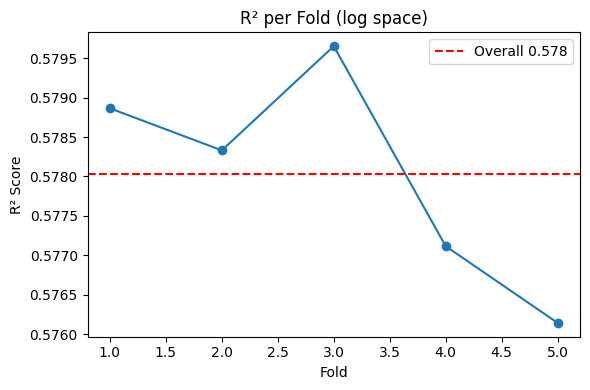

In [ ]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

r2_scores = []

fold = 1
for tr_idx, val_idx in gkf.split(X_full, y_log.values, groups):
    X_tr, y_tr = X_full[tr_idx], y_log.values[tr_idx]
    X_va, y_va = X_full[val_idx], y_log.values[val_idx]

    # (your model training block here...)

    oof[val_idx] = model.predict(X_va)
    fold_r2 = r2_score(y_va, oof[val_idx])
    r2_scores.append(fold_r2)
    print(f"Fold {fold} R^2: {fold_r2:.4f}")
    fold += 1

# Overall R²
overall_r2 = r2_score(y_log.values, oof)
print("Overall CV R^2:", overall_r2)

# Plot R² per fold
plt.figure(figsize=(6,4))
plt.plot(range(1, len(r2_scores)+1), r2_scores, marker="o")
plt.axhline(overall_r2, color="red", linestyle="--", label=f"Overall {overall_r2:.3f}")
plt.xlabel("Fold")
plt.ylabel("R² Score")
plt.title("R² per Fold (log space)")
plt.legend()
plt.tight_layout()
plt.show()


## Thank you so much!!